In [1]:
# Initial setup
import os
import torch
from select import select

os.environ["POLARS_UNKNOWN_EXTENSION_TYPE_BEHAVIOR"] = "load_as_storage"
from dotenv import load_dotenv
load_dotenv()
import polars as pl
%load_ext cuml.accel
import matplotlib.pyplot as plt
import numpy as np
db_eng = "adbc"
db_uri = os.getenv("DB_URI")
torch.cuda.set_device(0)
plt.style.use("default")

In [2]:
# Getting relevant latency data
df_clustered = pl.read_parquet("data/characteristics_clustered.parquet")
def get_trend_data(df, cluster_id, label="default"):
    ips = (df.filter(pl.col("cluster") == cluster_id)
        .select("ip_addr")
        .to_series()
        .to_list()
        )
    ip_list_str = ", ".join([f"('{ip}'::cidr)" for ip in ips])
    trend_query = f"""
        WITH target_ips(ip_addr) AS(
            VALUES {ip_list_str}
        )
        SELECT
            DATE_TRUNC('day', ping_date) as ds,
            AVG(ping_rttavg) as y
        FROM public.ping
        INNER JOIN target_ips USING (ip_addr)
        WHERE ping_ploss < 100
            AND ping_ploss >= 0
            AND ping_date >= '2009-01-01'
            AND ping_rttavg < 20000
        GROUP BY ds
        ORDER BY ds
    """
    df_trend = pl.read_database_uri(query=trend_query, uri=db_uri, engine=db_eng)
    df_trend.write_parquet(f"data/trend_cluster_{label}_{cluster_id}.parquet")
    print(f"Cluster {cluster_id} for {label} done")
    return df_trend

In [3]:
df = pl.read_parquet("data/characteristics_clustered.parquet")
profile = (
    df.group_by("cluster")
    .agg([
        pl.col("mean_rtt").mean().alias("avg_latency"),
        pl.col("jitter").mean().alias("avg_jitter"),
        pl.col("mean_loss").mean().alias("avg_packet_loss"),
        pl.len().alias("ip_count")
    ]).sort("avg_latency")
)
print(profile)

shape: (7, 5)
┌─────────┬─────────────┬─────────────┬─────────────────┬──────────┐
│ cluster ┆ avg_latency ┆ avg_jitter  ┆ avg_packet_loss ┆ ip_count │
│ ---     ┆ ---         ┆ ---         ┆ ---             ┆ ---      │
│ i32     ┆ f64         ┆ f64         ┆ f64             ┆ u32      │
╞═════════╪═════════════╪═════════════╪═════════════════╪══════════╡
│ 0       ┆ 51.29532    ┆ 19.503964   ┆ 0.992987        ┆ 98761    │
│ 3       ┆ 92.150177   ┆ 29.377244   ┆ 13.658567       ┆ 27295    │
│ 4       ┆ 234.121728  ┆ 49.884783   ┆ 2.101402        ┆ 58442    │
│ 2       ┆ 240.140195  ┆ 377.635713  ┆ 2.827615        ┆ 6912     │
│ 5       ┆ 452.65439   ┆ 1092.64368  ┆ 5.578666        ┆ 1189     │
│ 1       ┆ 1575.015971 ┆ 2098.083646 ┆ 13.837595       ┆ 144      │
│ 6       ┆ 5349.834674 ┆ 4624.546869 ┆ 54.339537       ┆ 4        │
└─────────┴─────────────┴─────────────┴─────────────────┴──────────┘


In [4]:
# Downloading trend data
for i in range(profile.height):
    get_trend_data(df, i, label="kmeans")

Cluster 0 for kmeans done
Cluster 1 for kmeans done
Cluster 2 for kmeans done
Cluster 3 for kmeans done
Cluster 4 for kmeans done
Cluster 5 for kmeans done
Cluster 6 for kmeans done


In [5]:
# NeuralProphet
import neuralprophet
import matplotlib.pyplot as plt
import pandas as pd

def train_and_save_neural_prophet_model(df, model_name, freq="D", normalize="off"):
    pdf = df.to_pandas()
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf["y"] = pd.to_numeric(pdf["y"])

    model = neuralprophet.NeuralProphet(
        weekly_seasonality=False,
        daily_seasonality=False,
        yearly_seasonality=True,
        normalize=normalize,
        trainer_config={"accelerator": "cuda", "devices": 1, "precision": "16-mixed"},
        learning_rate=0.01
    )

    print(f"Training model {model_name}")
    model.fit(pdf, freq=freq, batch_size=64)

    os.makedirs("models", exist_ok=True)
    save_path = f"models/{model_name}.np"
    neuralprophet.save(model, save_path)
    print(f"Model saved to {save_path}")

    return model

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [6]:
import neuralprophet
def visualize_forecast_neuralprophet(df, model_name, title, num_periods):
    save_path = f"models/{model_name}.np"
    if not os.path.exists(save_path):
        print(f"model file {save_path} not found")
        return

    print(f"Loading model from {save_path}")
    model = torch.load(save_path, weights_only=False)

    if hasattr(model, "restore_trainer"):
        model.restore_trainer(accelerator="cuda")

    pdf = df.to_pandas()
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf["y"] = pd.to_numeric(pdf["y"])

    future = model.make_future_dataframe(df=pdf, periods=num_periods, n_historic_predictions=True)
    forecast = model.predict(future)

    plt.figure(figsize=(15, 7))

    plt.scatter(pdf['ds'], pdf['y'], color='green', s=5, alpha=0.4, label='Actual data')

    plt.plot(forecast['ds'], forecast['yhat1'], label='NeuralProphet Model Fit', color='blue', lw=1.5, alpha=0.7)

    forecast_period = forecast.tail(num_periods)
    plt.plot(forecast_period['ds'], forecast_period['yhat1'], color='red', linewidth=2.5, label='Prediction')

    y_min = pdf['y'].min() * 0.8
    y_max = pdf['y'].max() * 1.2
    plt.ylim(y_min, y_max)

    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Latency (ms)", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.2)

    plt.show()

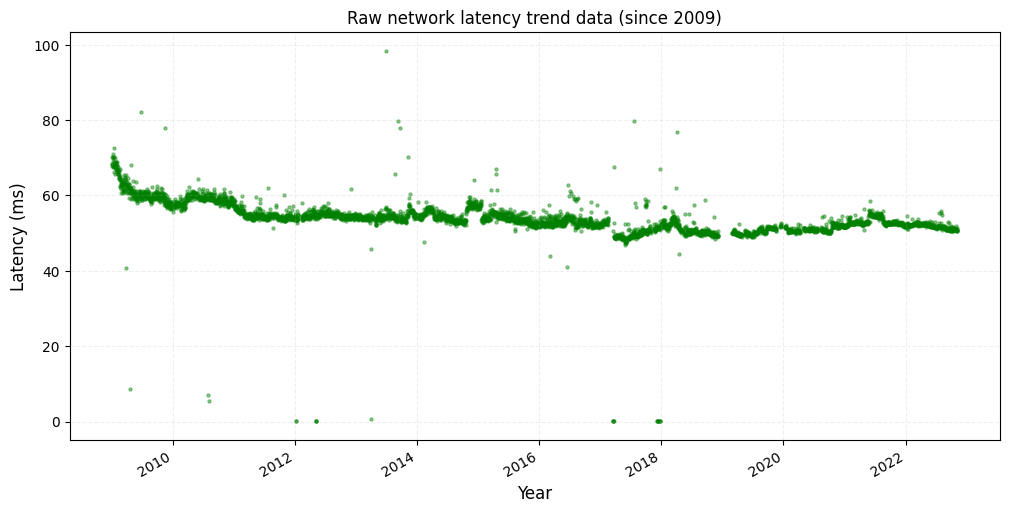

In [9]:
# Visualizing raw network latency trend data
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet").with_columns(pl.from_epoch("ds", time_unit="ns"))
plt.figure(figsize=(12, 6))
plt.scatter(core_df['ds'], core_df['y'], color='green', s=5, alpha=0.4, label='Actual data')
plt.title("Raw network latency trend data (since 2009)")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Latency (ms)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.gcf().autofmt_xdate()

plt.show()

In [10]:
# Training neuralprophet, no normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 38. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Model saved to models/kmeans_core.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


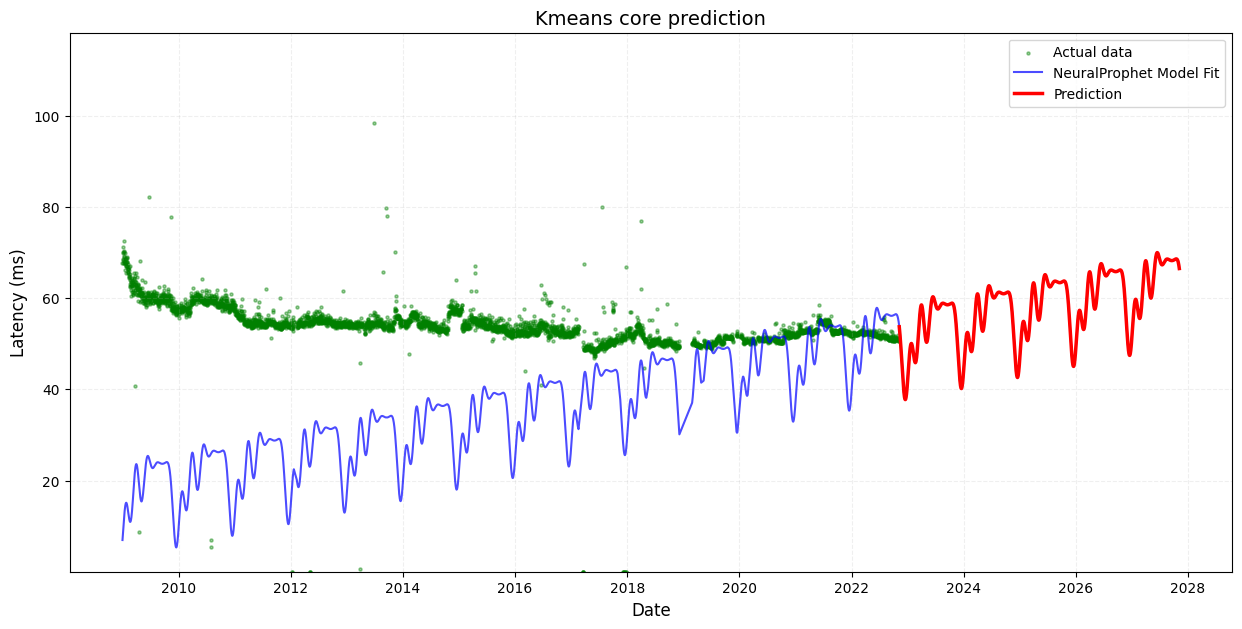

In [11]:
visualize_forecast_neuralprophet(core_df, "kmeans_core", "Kmeans core prediction", num_periods=(5*365))

In [12]:
# Training NeuralProphet with soft normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core_soft", normalize="soft")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core_soft


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_soft.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_soft.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


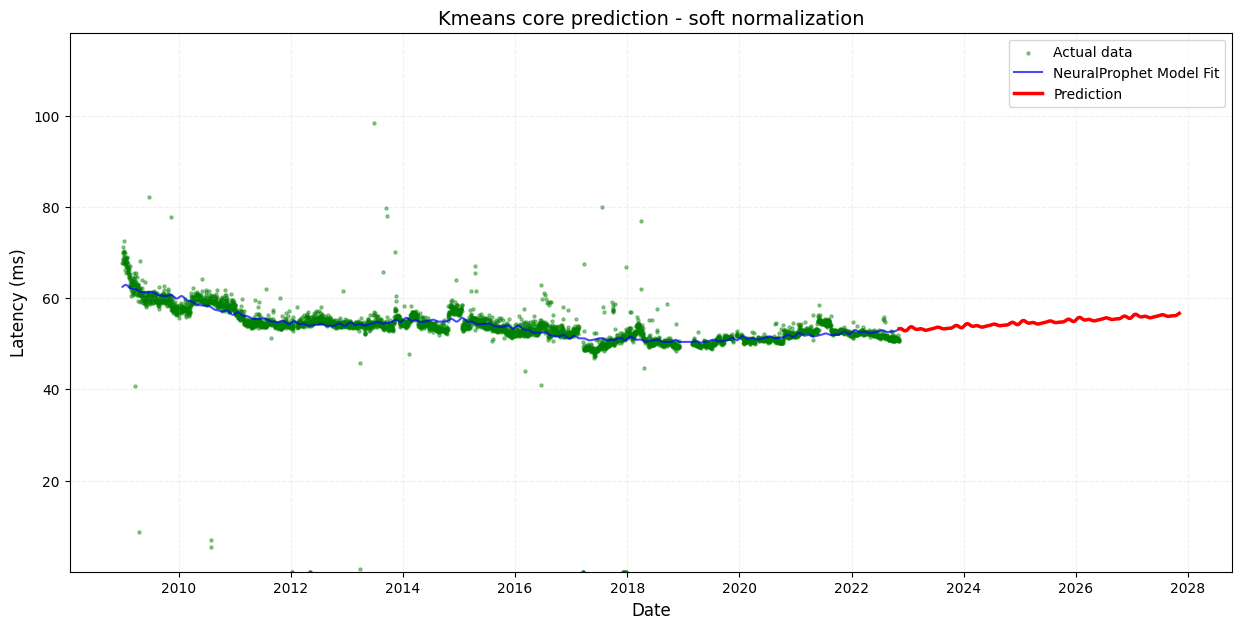

In [13]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_soft", "Kmeans core prediction - soft normalization", num_periods=(5*365))

In [14]:
# Training NeuralProphet with minmax normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core_minmax", normalize="minmax")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core_minmax


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_minmax.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_minmax.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


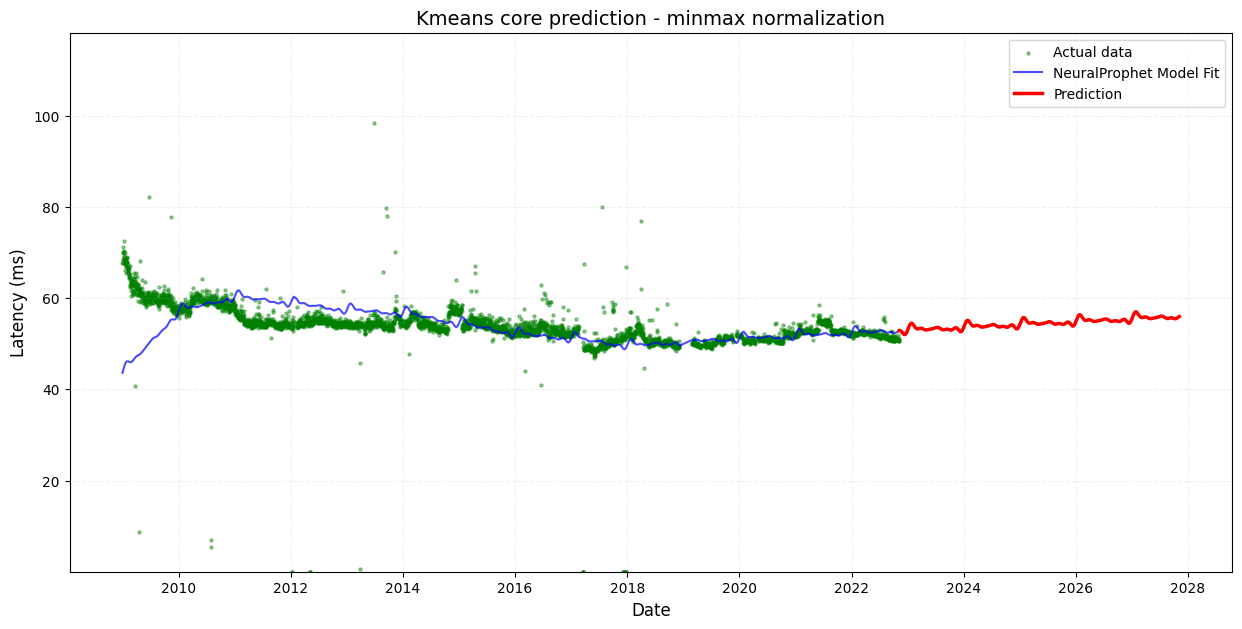

In [15]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_minmax", "Kmeans core prediction - minmax normalization", num_periods=(5*365))

In [16]:
# Training NeuralProphet with standardize normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core_standardize", normalize="standardize")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core_standardize


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_standardize.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_standardize.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


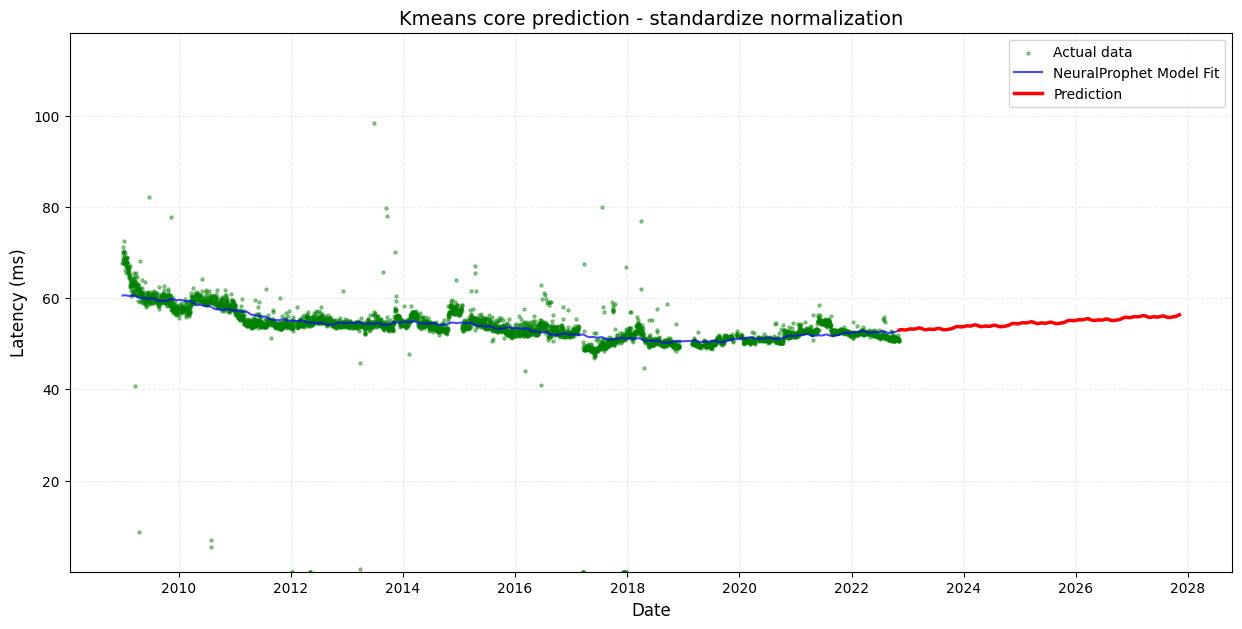

In [17]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_standardize", "Kmeans core prediction - standardize normalization", num_periods=(5*365))

In [34]:
# Model training with validation
def train_validate_and_save_neural_prophet_model(df, model_name, freq="D", normalize="off", learning_rate=0.01):
    pdf = df.to_pandas()
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf["y"] = pd.to_numeric(pdf["y"])

    model = neuralprophet.NeuralProphet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=True,
        normalize=normalize,
        trainer_config={"accelerator": "cuda", "devices": 1, "precision": "16-mixed"},
        loss_func="Huber",
        learning_rate=learning_rate
    )

    train_df, validation_df = model.split_df(pdf, freq=freq, valid_p=0.15)

    print(f"Training model {model_name}")
    metrics = model.fit(train_df, validation_df=validation_df, freq=freq, batch_size=64)
    metrics.to_csv(f"data/neuralprophet_model_{model_name}.csv")

    os.makedirs("models", exist_ok=True)
    save_path = f"models/{model_name}.np"
    neuralprophet.save(model, save_path)
    print(f"Model saved to {save_path}")

    return metrics.tail(1)

In [35]:
# Training neuralprophet, no normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 36. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
69,7.435594,9.431116,7.286772,0.0,69,15.5058,0.0,24.055073,28.120205,15.505896,0.0


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


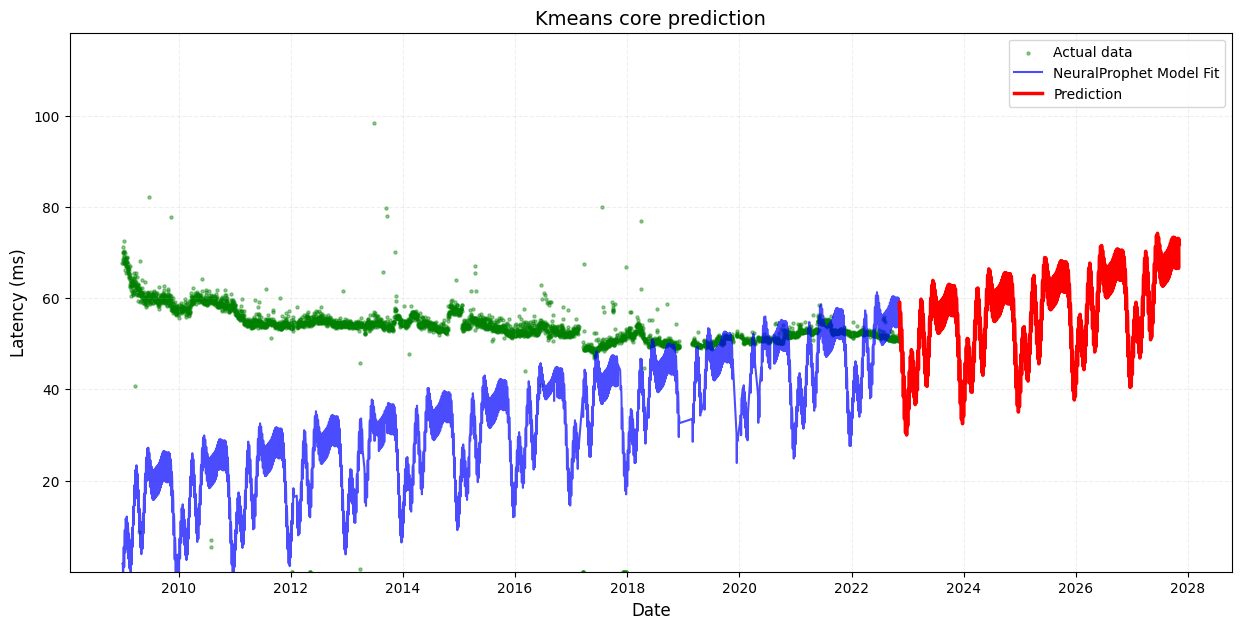

In [36]:
visualize_forecast_neuralprophet(core_df, "kmeans_core", "Kmeans core prediction", num_periods=(5*365))

In [37]:
# Training neuralprophet, soft normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_soft", normalize="soft")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_soft


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_soft.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
69,1.431169,1.818671,0.001501,0.0,69,0.004493,0.0,1.690638,3.702361,0.004473,0.0


Loading model from models/kmeans_core_soft.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


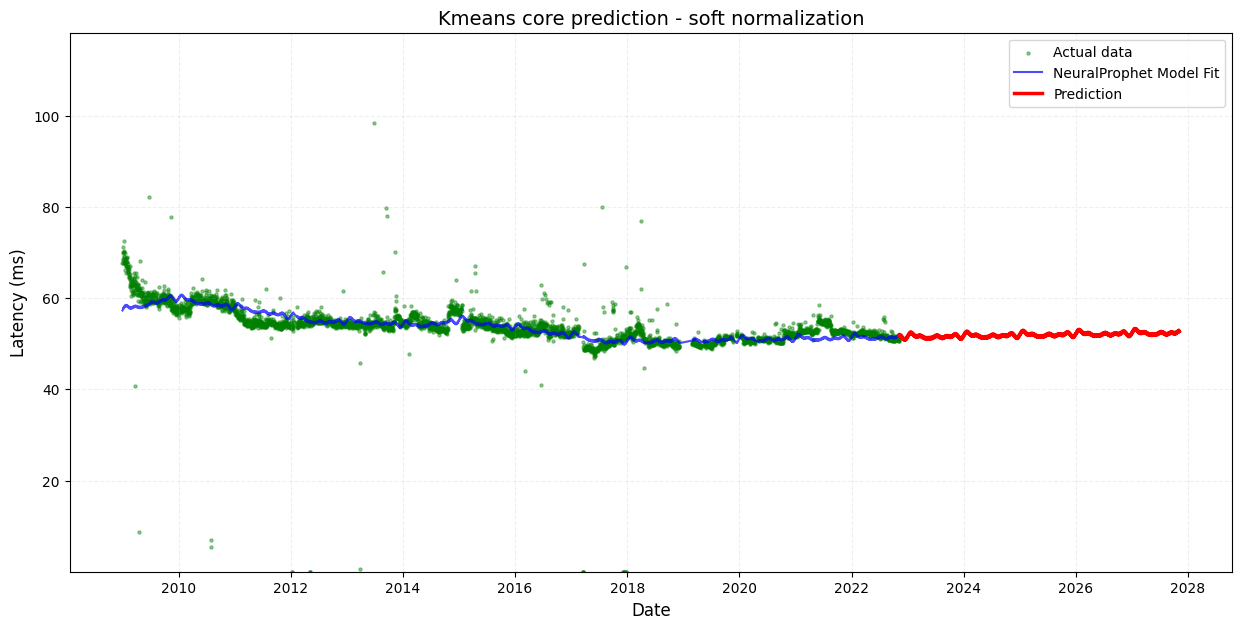

In [38]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_soft", "Kmeans core prediction - soft normalization", num_periods=(5 * 365))

In [39]:
# Training NeuralProphet with minmax normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_minmax", normalize="minmax")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_minmax


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_minmax.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
69,1.319773,1.67895,0.000485,0.0,69,0.002004,0.0,1.460804,3.37383,0.001993,0.0


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_minmax.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


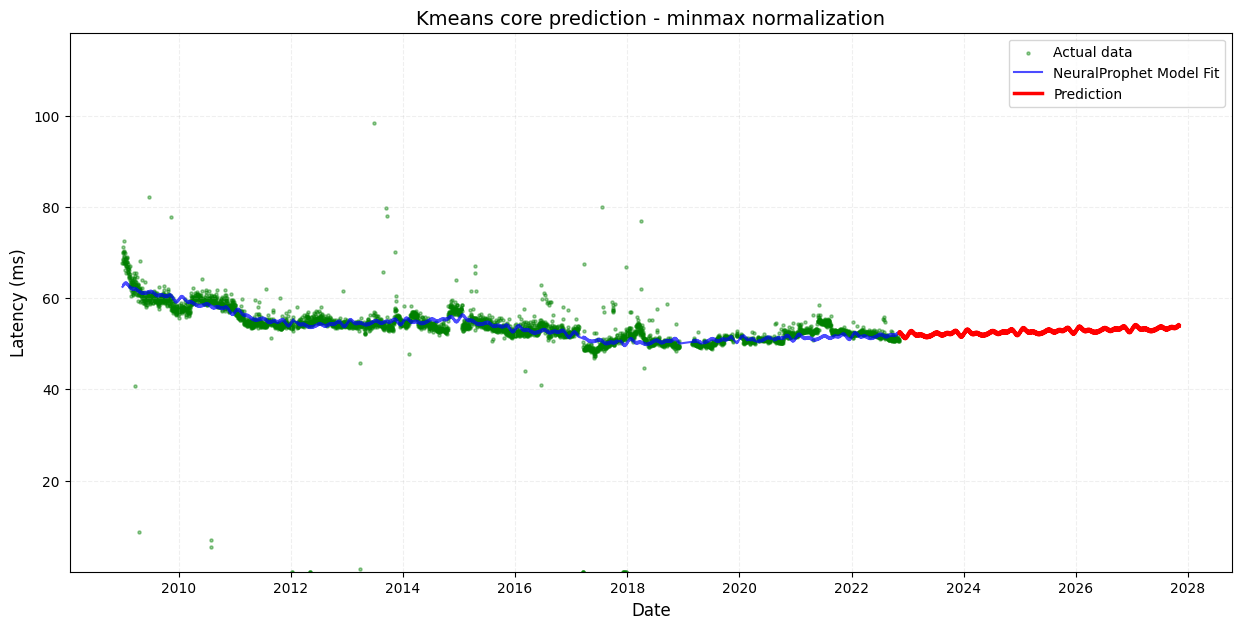

In [40]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_minmax", "Kmeans core prediction - minmax normalization", num_periods=(5 * 365))

In [41]:
# Training NeuralProphet with standardize normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_standardize", normalize="standardize")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_standardize


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_standardize.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
69,1.432297,1.817474,0.146083,0.0,69,0.120268,0.0,1.446951,3.433157,0.11974,0.0


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_standardize.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


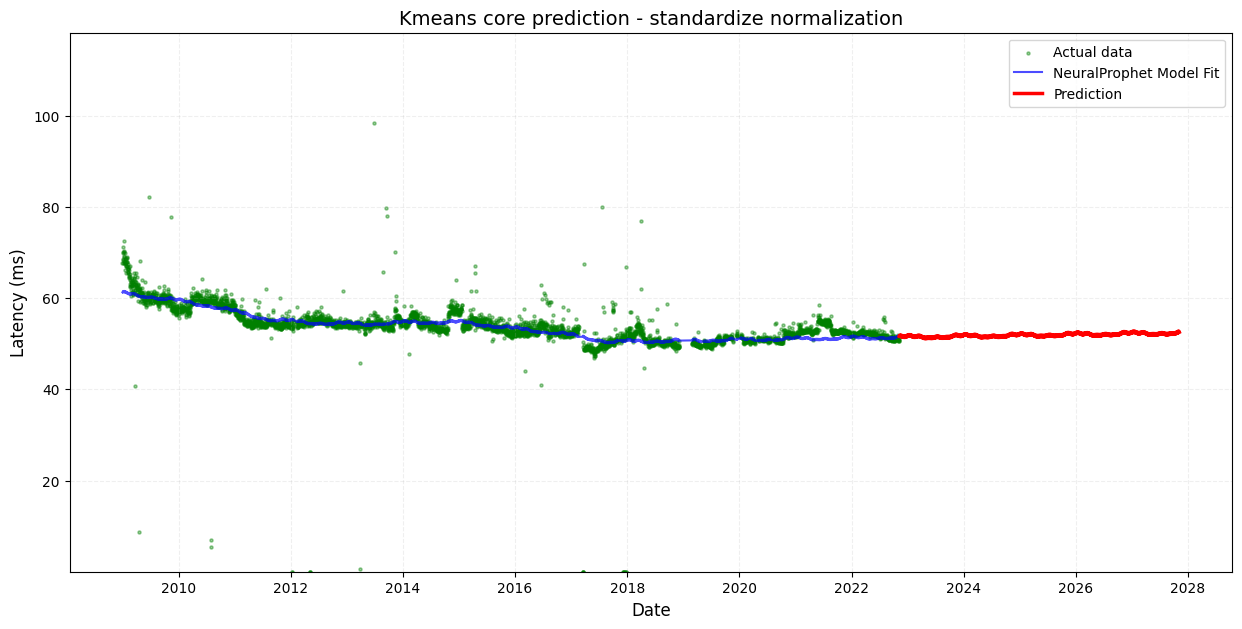

In [42]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_standardize", "Kmeans core prediction - standardize normalization", num_periods=(5 * 365))

In [43]:
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
q_low = core_df["y"].quantile(0.01)
q_high = core_df["y"].quantile(0.99)
core_df_clipped = core_df.filter((pl.col("y") > q_low) & (pl.col("y") < q_high))
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_minmax_no_outliers", normalize="minmax")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_minmax_no_outliers


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_minmax_no_outliers.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
69,1.417771,1.803495,0.000559,0.0,69,0.002501,0.0,2.098018,4.378887,0.002528,0.0


Loading model from models/kmeans_core_minmax_no_outliers.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.028% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


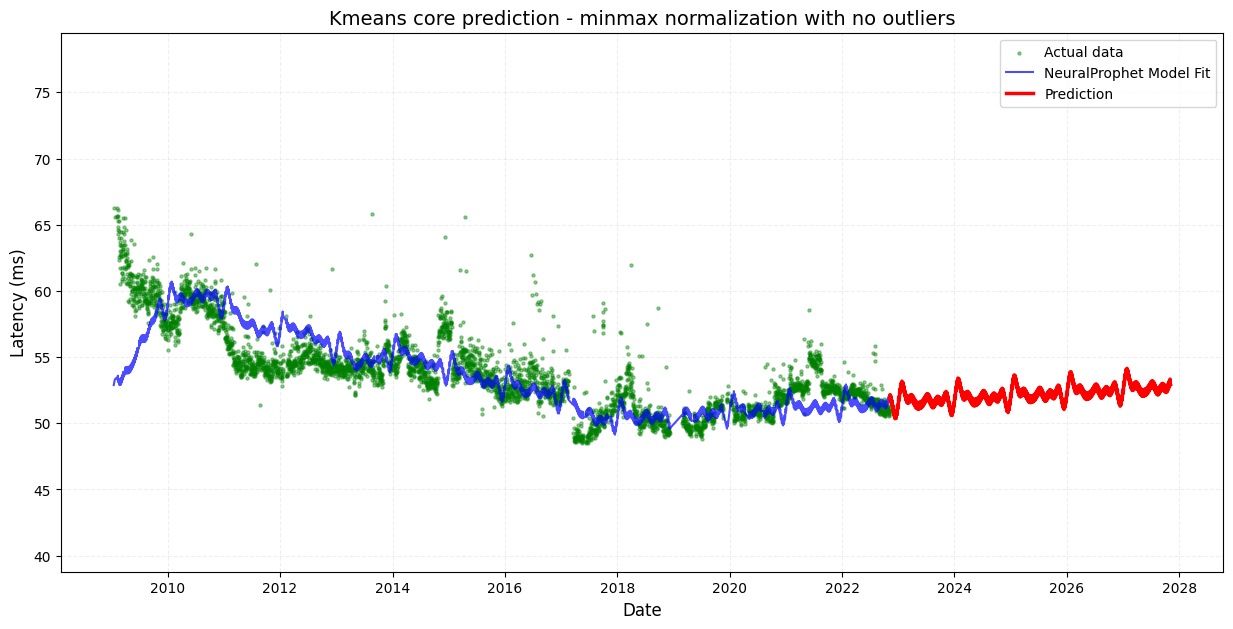

In [44]:
visualize_forecast_neuralprophet(core_df_clipped, "kmeans_core_minmax_no_outliers", "Kmeans core prediction - minmax normalization with no outliers", num_periods=(5 * 365))

In [48]:
# XGBoost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_features_for_xgboost(df):
    df = df.to_pandas()
    df["ds"] = pd.to_datetime(df["ds"])

    df["dayofweek"] = df["ds"].dt.dayofweek
    df["quarter"] = df["ds"].dt.quarter
    df["month"] = df["ds"].dt.month
    df["year"] = df["ds"].dt.year
    df["dayofyear"] = df["ds"].dt.dayofyear

    for i in range(1, 7):
        df[f"y_{i}_day_lag"] = df["y"].shift(i)

    df["y_1_week_lag"] = df["y"].shift(7)
    df["y_1_month_lag"] = df["y"].shift(30)
    df["y_1_year_lag"] = df["y"].shift(365)
    
    for win in [7, 30, 365]:
        label = "week" if win == 7 else "month" if win == 30 else "year"
        df[f"y_1_{label}_mean"] = df["y"].shift(1).rolling(window=win).mean()
        df[f"y_1_{label}_std"]  = df["y"].shift(1).rolling(window=win).std()
        df[f"y_1_{label}_max"]  = df["y"].shift(1).rolling(window=win).max()
        df[f"y_1_{label}_min"]  = df["y"].shift(1).rolling(window=win).min()
    
    return df.dropna()

def train_xgboost(pdf):
    train_size = int(len(pdf) * 0.85)
    train, test = pdf.iloc[:train_size], pdf.iloc[train_size:]
    features = [
    "dayofweek", "quarter", "month", "year", "dayofyear",
    "y_1_day_lag", "y_2_day_lag", "y_3_day_lag", "y_4_day_lag", "y_5_day_lag", "y_6_day_lag",
    "y_1_week_lag", "y_1_month_lag", "y_1_year_lag",
    "y_1_week_mean", "y_1_month_mean", "y_1_year_mean",
    "y_1_week_std", "y_1_month_std", "y_1_year_std",
    "y_1_week_max", "y_1_month_max", "y_1_year_max",
    "y_1_week_min", "y_1_month_min", "y_1_year_min"
    ]
    target = 'y'
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    model = xgb.XGBRegressor(
        tree_method='hist',
        device='cuda',
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=100
    )

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    train_mae = mean_absolute_error(y_train, model.predict(X_train))

    print(f"XGBoost Daily MAE: {mae:.2f} ms")
    print(f"XGBoost Daily RMSE: {rmse:.2f} ms")
    print(f"XGBoost Daily train MAE: {train_mae:.2f} ms")

    return model

def visualize_xgboost_forecast(pdf, model, features, title, num_periods):
    pdf = pdf.sort_values('ds').reset_index(drop=True)
    train_size = int(len(pdf) * 0.75)
    test_df = pdf.iloc[train_size:].copy()

    test_df['preds'] = model.predict(test_df[features])

    history_buffer = pdf['y'].tail(365).to_list()
    last_date = pdf['ds'].max()
    future_dates = pd.date_range(start=last_date, periods=num_periods + 1, freq='D')[1:]

    future_preds = []
    booster = model.get_booster()

    for date in future_dates:
        feat_dict = {
            "dayofweek": date.dayofweek,
            "quarter": date.quarter,
            "month": date.month,
            "year": date.year,
            "dayofyear": date.dayofyear
        }

        for i in range(1, 7):
            feat_dict[f"y_{i}_day_lag"] = history_buffer[-i]

        feat_dict["y_1_week_lag"] = history_buffer[-7]
        feat_dict["y_1_month_lag"] = history_buffer[-30]
        feat_dict["y_1_year_lag"] = history_buffer[-365]

        for win, label in [(7, "week"), (30, "month"), (365, "year")]:
            window_data = history_buffer[-win:]
            feat_dict[f"y_1_{label}_mean"] = np.mean(window_data)
            feat_dict[f"y_1_{label}_std"]  = np.std(window_data)
            feat_dict[f"y_1_{label}_max"]  = np.max(window_data)
            feat_dict[f"y_1_{label}_min"]  = np.min(window_data)

        X_input = np.array([[feat_dict[f] for f in features]], dtype=np.float32)

        dinput = xgb.DMatrix(X_input, feature_names=features)
        pred = booster.predict(dinput)[0]
        future_preds.append(pred)
        history_buffer.append(pred)
        history_buffer.pop(0)

    plt.figure(figsize=(15, 8))
    plt.scatter(pdf['ds'], pdf['y'], color='green', s=2, alpha=0.1, label="Actual data")
    plt.plot(test_df['ds'], test_df['preds'], color='blue', lw=1, label="XGBoost validation fit", alpha=0.8)
    plt.plot(future_dates, future_preds, color='red', lw=2, linestyle='--', label="Forecast")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Latency (ms)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

In [49]:
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
pdf = create_features_for_xgboost(core_df)
xgb_daily_model = train_xgboost(pdf)

[0]	validation_0-rmse:1.39743
[100]	validation_0-rmse:1.04602
[115]	validation_0-rmse:1.07255
XGBoost Daily MAE: 0.73 ms
XGBoost Daily RMSE: 0.97 ms
XGBoost Daily train MAE: 1.57 ms


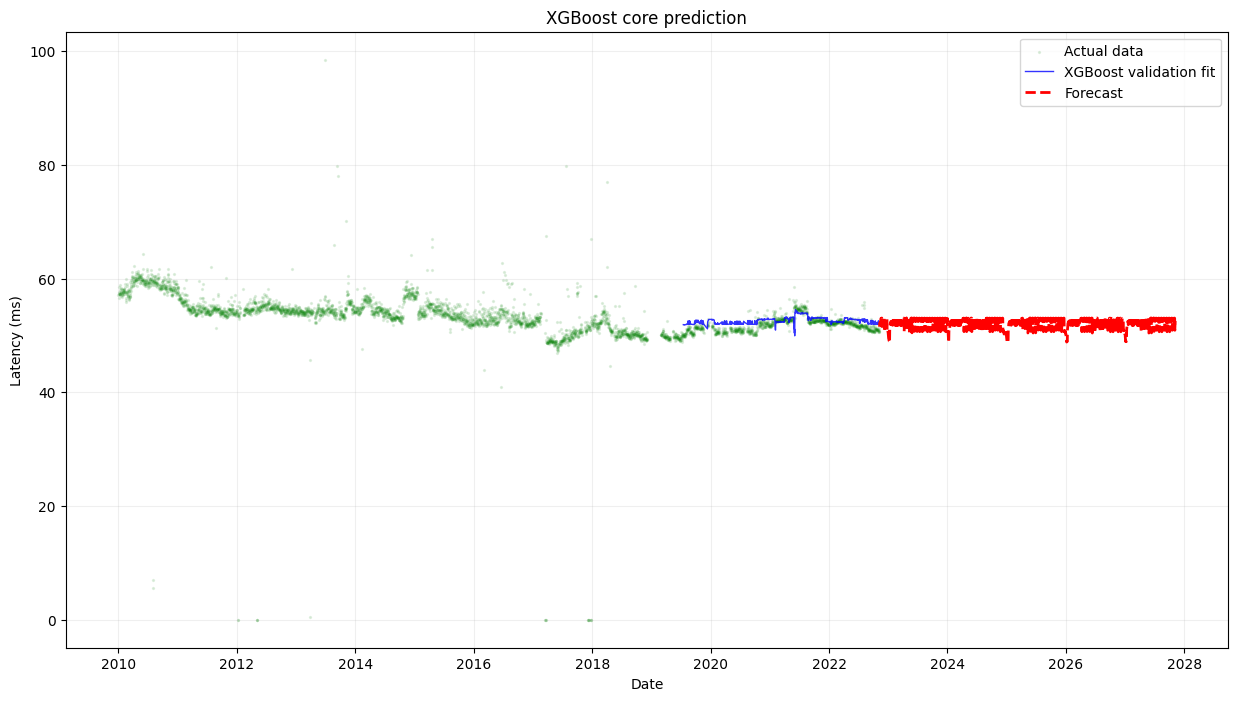

In [51]:
features = [
    "dayofweek", "quarter", "month", "year", "dayofyear",
    "y_1_day_lag", "y_2_day_lag", "y_3_day_lag", "y_4_day_lag", "y_5_day_lag", "y_6_day_lag",
    "y_1_week_lag", "y_1_month_lag", "y_1_year_lag",
    "y_1_week_mean", "y_1_month_mean", "y_1_year_mean",
    "y_1_week_std", "y_1_month_std", "y_1_year_std",
    "y_1_week_max", "y_1_month_max", "y_1_year_max",
    "y_1_week_min", "y_1_month_min", "y_1_year_min"
]
visualize_xgboost_forecast(pdf, xgb_daily_model, features, "XGBoost core prediction", 5*365)